In [3]:
import numpy as np
import pandas as pd
import nltk
import math as ma                                   # To perform log func
import itertools                                    #this is to slice the dictionary to get only max frequecvy values
from sklearn import datasets
from nltk.corpus import stopwords                   #to get list of stopwords(Natural Language Toolkits)(16 lang stopwords)
from sklearn import model_selection
from nltk.tokenize import word_tokenize             #used in removing stopwords from data
stop_words = set(stopwords.words('english'))

In [8]:
# return the probability that document(x) belong to that particular class
def probability(dictionary,x,clas): 
    
    count=ma.log(dictionary[clas]["count"])-ma.log(dictionary["total"])     # it is probability of(y=class(clas))
    features_number=len(dictionary[clas].keys())-2                          #total number of features(2-count,grand_total)
    
    for j in range(features_number):    # calculting the probabilty over each feature the later we will take log() sum of all            
        if(x[j]==0):                    #if input x have zero frequency over the feature so its probabiluty will not counted
            continue
        #Apply Laplace correction
        count_xj_in_feature_j=dictionary[clas][j]+1      # it is the total frequency of feature j in class->clas
        count_clas_ele_in_feature=dictionary[clas]["Grand_total"]+ features_number # it is total number of words in class->clas
        p=ma.log(count_xj_in_feature_j)-ma.log(count_clas_ele_in_feature)   #summing all small probabilities of all features
        count=count+p
    return count                                                                   # returning the probabilty

In [9]:
#output(prediction) corresponding to that particular row(document) 
def singlecol(dictionary,x):    
    
    best_prob=-1000             
    best_cls=-1                    
    classes=dictionary.keys()      #dictionary .keys have all the classes names
    val=True
    for clas in classes:           # checking probabily on one class at a time
        if clas=="total":          # total is not a class so ignore it
            continue
        clas_p=probability(dictionary,x,clas)   #what is the probability that document belong to that particular class
        if(val or clas_p>best_prob):
            best_prob=clas_p
            best_cls=clas
        val=False
    return best_cls                 #returns the best_cls with maximum probability

In [10]:
def predict(dictionary,xx_test):    
    
    lst=[]
    for x in xx_test:                    #going through test_data row wise(document wise)
                                         #predict that document belong to which class
        pred=singlecol(dictionary,x)    
        lst.append(pred)
    return lst

In [11]:
# this function is to train algorithm over training data
def fit(xx_train,y_train,features):              
    result={}                           
    classes=set(y_train)                         #total no. of possible classes
    
    for current_class in classes:                
        result[current_class]={}
        result["total"]=len(xx_train)            # total classes
        current_class_rows=(y_train==current_class)            
        x_train_current=xx_train[current_class_rows]           #spliting x_train for only current_class
        y_train_current=y_train[current_class_rows]            #spliting y_train for only current_class
        result[current_class]["count"]=len(x_train_current)   # count of that corresponding current_class
              
        a=0
        for j in range(len(features)):
            result[current_class][j]=(x_train_current[:,j].sum())         #it will hold frequency of feature j
            a+=result[current_class][j]
        result[current_class]["Grand_total"]=a                            #it will hold count of entire words in current_class
        
    return result

In [13]:
news=datasets.fetch_20newsgroups()                  # loading data from datasets(news name dataframe)
x=news.data
y=news.target

x_train,x_test,y_train,y_test=model_selection.train_test_split(x,y,test_size=0.1,random_state=0) 

len_data=len(x_train)
d={}                          #we will store frequency of each word after removing stop_words
for i in range(len_data):
    data=x_train[i]
    word_tokens = word_tokenize(data)
    
    filtered_sentence=[]
    for w in word_tokens:
        if  w not in stop_words:
            filtered_sentence.append(w)
            
    for word in filtered_sentence:
        if word in d:
            d[word]+=1
        else:
            d[word]=1

new_dict={}                 #this is the reverse sorted form of dictionary 
for key,value in sorted(d.items(),key=lambda item: item[1],reverse=True): #item[1] 1=sorted by value
    new_dict[key]=value
    
b=dict(itertools.islice(new_dict.items(),3000))  # slicing over bigger ditionary to get top 3000 data only
#print(b)
q=0
a={}
for key in b.keys():
    if q<=25:
        q+=1
        continue
    a[key]=b[key]
#print(a)
features=[]   # features is the list of keys of dictionary (a) 
for i in a.keys():
    features.append(i)

#modifing x_train to xx_train which is 2d and index store frequency of each word(feature) of particular document(row) 
xx_train=np.zeros((len(x_train),len(features))) 
for i in range(len(x_train)):
    data=x_train[i]
    word_tokens = word_tokenize(data)
    filtered_sentence=[]
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    for j in filtered_sentence:
        if j in features:
            xx_train[i][features.index(j)]+=1

#modifing x_test to xx_test which is 2d and index store frequency of each word(feature) of particular document(row) 
xx_test=np.zeros((len(x_test),len(features)))           
for i in range(len(x_test)):
    data2=x_test[i]
    word_tok=word_tokenize(data2)
    filtered_sentence=[]
    for w in word_tok:
        if w not in stop_words:
            filtered_sentence.append(w)
    for j in filtered_sentence:
        if j in features:
            xx_test[i][features.index(j)]+=1


            
            
#calling fit function over data xx_train and y_train 
final_dict=fit(xx_train,y_train,features)   

# predict will return the output list of classes  (output)
y_pred=predict(final_dict,xx_test)       

print("  *************This classification due to scratch**************  ")
from sklearn.metrics import classification_report,confusion_matrix      
print(classification_report(y_test,y_pred))                 
print(confusion_matrix(y_test,y_pred))          

  *************This classification due to scratch************  
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        37
           1       0.46      0.83      0.59        65
           2       0.33      0.02      0.04        54
           3       0.59      0.70      0.64        76
           4       0.65      0.76      0.70        66
           5       0.86      0.63      0.73        59
           6       0.65      0.92      0.76        50
           7       0.88      0.70      0.78        53
           8       0.74      0.92      0.82        63
           9       0.73      0.93      0.82        57
          10       0.98      0.63      0.77        65
          11       1.00      0.81      0.90        53
          12       0.63      0.63      0.63        57
          13       0.80      0.89      0.84        53
          14       0.84      0.78      0.81        65
          15       0.95      0.85      0.90        73
          16     

In [16]:
print('  **************** this classification is due to sklearn **********************  ')

from sklearn.naive_bayes import MultinomialNB   # now doing the same fit and predict by MultinomialNB Classifier
algo=MultinomialNB()
algo.fit(xx_train,y_train)
y_pred2=algo.predict(xx_test)
print("score = ",algo.score(xx_test,y_test))   

print(classification_report(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))

  **************** this classification is due to sklearn **********************  
score =  0.765017667844523
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        37
           1       0.46      0.77      0.58        65
           2       0.33      0.02      0.04        54
           3       0.57      0.76      0.66        76
           4       0.70      0.76      0.73        66
           5       0.78      0.61      0.69        59
           6       0.65      0.86      0.74        50
           7       0.82      0.75      0.78        53
           8       0.77      0.95      0.85        63
           9       0.78      0.88      0.83        57
          10       0.98      0.77      0.86        65
          11       0.98      0.81      0.89        53
          12       0.69      0.74      0.71        57
          13       0.88      0.83      0.85        53
          14       0.90      0.83      0.86        65
          15       0.95   

# comparision of prediction due to scratch and prediction due to sklearn

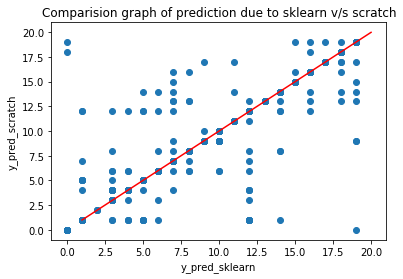

In [19]:
import matplotlib.pyplot as plt
x=[1,20]
y=[1,20]
y_pred_sklearn=y_pred2
y_pred_scratch=y_pred
plt.scatter(y_pred_sklearn,y_pred_scratch)
plt.ylabel("y_pred_scratch")
plt.xlabel("y_pred_sklearn")
plt.title("Comparision graph of prediction due to sklearn v/s scratch")
plt.plot(x,y,'r')
plt.show()

since there is maximum density along the line (y_pred_sklearn=y_pred_scratch) so predictions due to sklearn and scratch are nearly same